In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import dlib
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

2024-07-09 02:26:31.724564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 02:26:31.970077: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/josh/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-07-09 02:26:31.970104: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-07-09 02:26:32.746872: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: lib

In [2]:
def align_face(image):
    detector = dlib.get_frontal_face_detector()
    shape_predictor = dlib.shape_predictor('./pretrained_models/shape_predictor_5_face_landmarks.dat')
    
    detections = detector(img, 0)
    faces = dlib.full_object_detections()
    for detection in detections:
        faces.append(shape_predictor(img, detection))
    
    chip_details = dlib.get_face_chip_details(faces)
    
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rotation_matrix = cv2.getRotationMatrix2D(image_center, np.rad2deg(chip_details[0].angle), 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[1::-1], flags = cv2.INTER_LINEAR)
    
    return rotated_image

In [3]:
def crop_image(image):
    # Creating a FaceLandmarker object.
    base_options = python.BaseOptions(model_asset_path = './pretrained_models/face_landmarker.task');
    options = vision.FaceLandmarkerOptions(base_options = base_options, num_faces = 1);
    detector = vision.FaceLandmarker.create_from_options(options);

    # Convert the image to MediaPipe format.
    mp_image = mp.Image(image_format = mp.ImageFormat.SRGB, data = image);

    # Detect face landmarks.
    detection_result = detector.detect(mp_image);
    
    # Calculate the bounding box for the face based off of the minimum and maximum coordinates in found landmarks.
    # Landmarks are in normalized coordinates, so must be converted back to pixel coordinates.
    min_x = int(min([k.x for k in detection_result.face_landmarks[0]]) * image.shape[1])
    max_x = int(max([k.x for k in detection_result.face_landmarks[0]]) * image.shape[1])
    min_y = int(min([k.y for k in detection_result.face_landmarks[0]]) * image.shape[0])
    max_y = int(max([k.y for k in detection_result.face_landmarks[0]]) * image.shape[0])
    
    cropped_image = image[min_y:max_y, min_x:max_x, ::]
    
    return cropped_image

In [4]:
def pad_image(image, end_dim = (250, 250), color = (0, 0, 0)):
    old_height, old_width, channels = image.shape
    new_height, new_width = end_dim
    
    x_center = (new_width - old_width) // 2
    y_center = (new_height - old_height) // 2
    
    y_top = y_center + old_height
    x_right = x_center + old_width
    
    padded_image = np.full((new_height, new_width, channels), color, dtype = np.uint8)
    
    padded_image[y_center:y_top, x_center:x_right] = image
    
    return padded_image

In [5]:
raw_path = './data/raw'

In [6]:
name = 'Abdullah al-Attiyah'
number = 3
name_formatted = '_'.join(name.split()) + f'_{number:04d}.jpg'

In [7]:
name_formatted

'Abdullah_al-Attiyah_0003.jpg'

In [8]:
if os.path.exists(os.path.join(raw_path, 'test', name_formatted)):
    image_dir = 'test'
else:
    image_dir = 'train'

img_path = os.path.join(raw_path, image_dir, name_formatted)

In [9]:
img = cv2.imread(img_path)

In [10]:
rotated_img = align_face(img)

In [11]:
cropped_img = crop_image(rotated_img)

libEGL warning: DRI2: failed to authenticate
I0000 00:00:1720506394.617937   19903 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720506394.632478   19962 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: llvmpipe (LLVM 12.0.0, 256 bits)
W0000 00:00:1720506394.640488   19903 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [12]:
padded_img = pad_image(cropped_img)

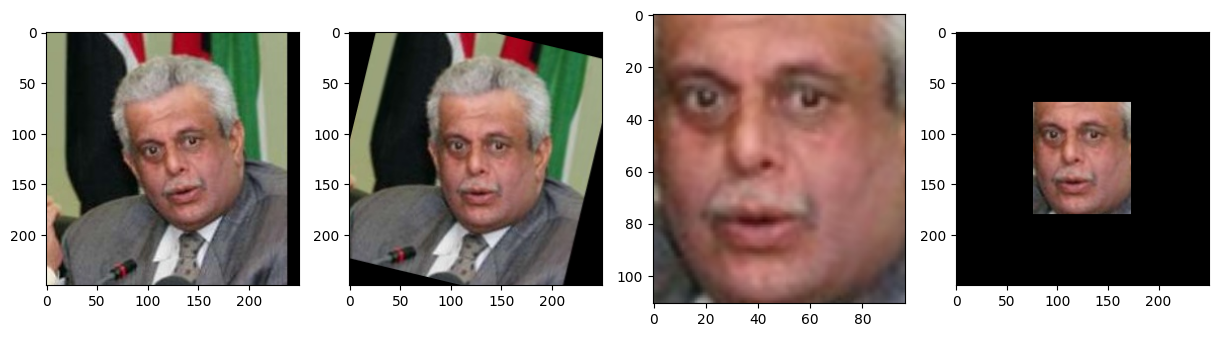

In [13]:
fig, ax = plt.subplots(1, 4, figsize = (15, 10))

ax[0].imshow(img[:, :, ::-1]);
ax[1].imshow(rotated_img[:, :, ::-1]);
ax[2].imshow(cropped_img[:, :, ::-1]);
ax[3].imshow(padded_img[:, :, ::-1]);